In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
# from sklearn.model_selection import train_test_split
import xgboost as xgb

In [53]:
holidays = pd.read_csv("./data/holidays_events.csv")
oil = pd.read_csv("./data/oil.csv")
stores = pd.read_csv("./data/stores.csv")
trans = pd.read_csv("./data/transactions.csv")

train_data = pd.read_csv("./data/train.csv")
test_data = pd.read_csv("./data/test.csv")
sample_submission = pd.read_csv("./data/sample_submission.csv")

In [54]:
data_set = [holidays, oil, stores, trans, train_data, test_data]

In [55]:
# Check NA & NULL and change date type
for i in range(len(data_set)):
    if 'date' in data_set[i]:
        data_set[i]['date'] = pd.to_datetime(data_set[i]["date"])
    if data_set[i].isna().sum().sum() or data_set[i].isnull().sum().sum():
        print(f'There are {max(data_set[i].isna().sum().sum(), data_set[i].isnull().sum().sum())} missng values in the number {i} position of the data set.')

There are 43 missng values in the number 1 position of the data set.


In [56]:
test_data['test'] = 1
train_data['test'] = 0
df = pd.concat([train_data, test_data], axis = 0)

df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day_name'] = df['date'].dt.dayofweek
df['day'] = df['date'].dt.day

df = pd.merge(df, stores[['store_nbr', 'type']],
              on = 'store_nbr', how = 'left')
Oil = oil.copy()
# Use 30 days rolling mean to fill na in oil data set.
Oil = pd.merge(pd.DataFrame({'date' : df.date.unique()}), Oil,
               on = 'date', how = 'left')
# _ = Oil.dcoilwtico.fillna(Oil.dcoilwtico.rolling(30, min_periods = 1).mean(), inplace = True)
# Oil.dcoilwtico[0] = round(Oil.dcoilwtico[1:31].mean(), 2)

_ = Oil.dcoilwtico.interpolate(method = 'linear', inplace = True)
Oil.dcoilwtico[0] = Oil.dcoilwtico.iloc[1]

df = pd.merge(df, Oil,
              on = 'date', how = 'left')
df = df.sort_values(by = ['family', 'date']).rename(columns = {'type' : 'store_type',
                                                               'dcoilwtico' : 'oil_price'})
# df = pd.merge(df, holidays[['date', 'type', 'locale', 'transferred']],
#               on = 'date', how = 'left')
# df['type'] = df['type'].fillna(0)
# df['transferred'] = df['transferred'].fillna(0.0).astype(float)
# df['locale'] = df['locale'].fillna(0)

# holidays[holidays.date == '2012-06-25']

Train_data = df.copy()
Train_data = Train_data[Train_data.test == 0] # for graph first

<ipython-input-56-c86cccffae17>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Oil.dcoilwtico[0] = Oil.dcoilwtico.iloc[1]


# Plot oil price and filling na

In [59]:
# plt.subplots(figsize = (18, 12))
# sns.set_theme(context={'font.size': 20})
# plot = sns.lineplot(data = oil[:61], x = "date", y = "dcoilwtico", color = 'blue', label = 'before')
# plot = sns.lineplot(data = Oil[:61], x = "date", y = "dcoilwtico", color = 'r', alpha = 0.3, label = 'after')
# plot.set_xlabel('Date', fontsize = 18)
# plot.set_ylabel("Oil Price", fontsize = 18)
# plot.set_title('Filling Oil Missing Value', fontsize = 30)
# plot.tick_params(axis = 'both', labelsize = 16)

# print(pd.merge(Oil, oil, on = 'date', how = 'left')[:10])
# print(pd.merge(Oil, oil, on = 'date', how = 'left')[31:41])

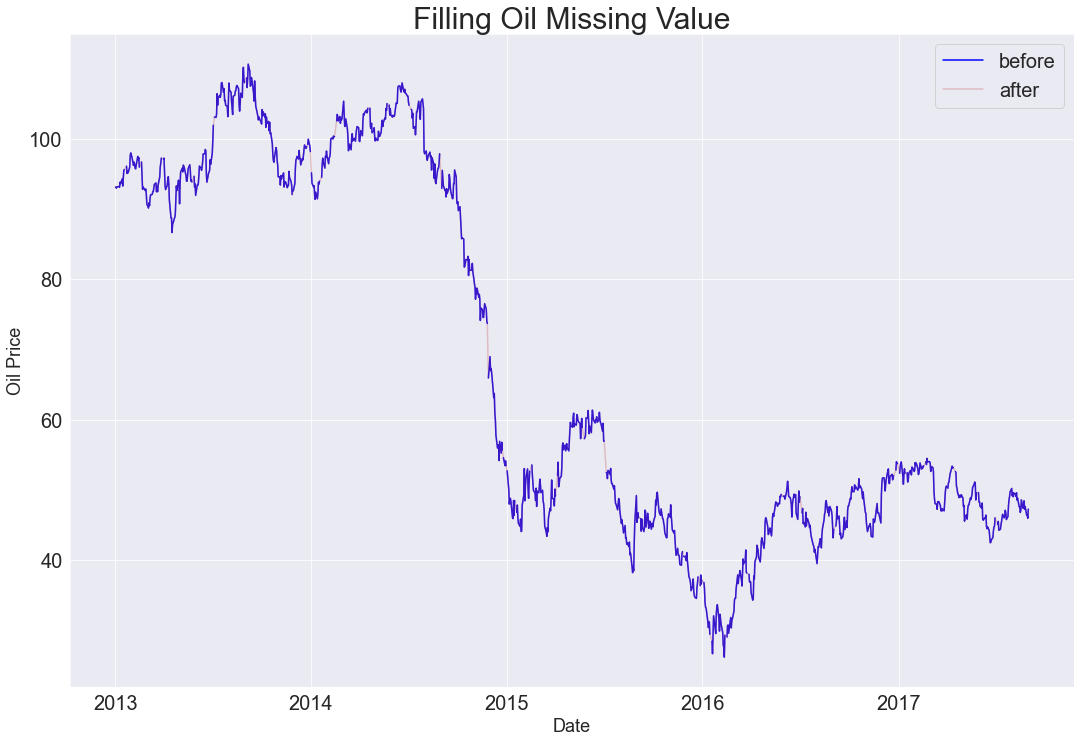

In [60]:
plt.subplots(figsize = (18, 12))
sns.set_theme(context={'font.size': 20})
plot = sns.lineplot(data = oil, x = "date", y = "dcoilwtico", color = 'blue', label = 'before')
plot = sns.lineplot(data = Oil, x = "date", y = "dcoilwtico", color = 'r', alpha = 0.3, label = 'after')
plot.set_xlabel('Date', fontsize = 18)
plot.set_ylabel("Oil Price", fontsize = 18)
plot.set_title('Filling Oil Missing Value', fontsize = 30)
plt.savefig('Oil_price.png', dpi = 400, bbox_inches = 'tight')

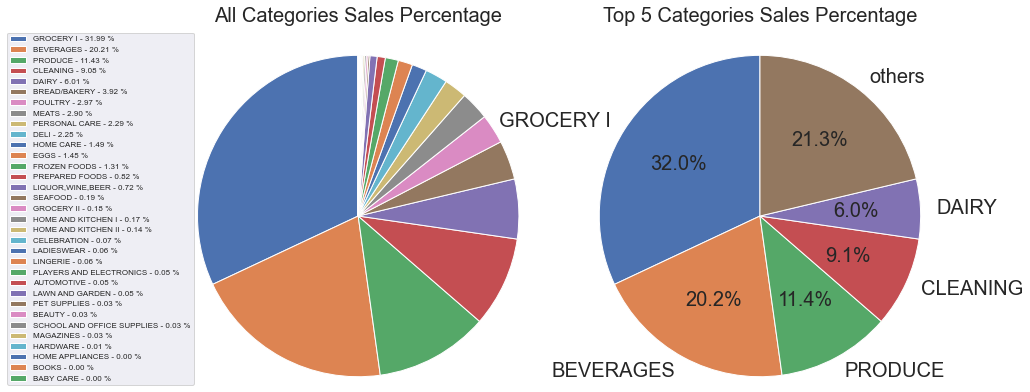

In [61]:
Sale_per = 100 * Train_data.groupby(by = ['family']).sum()['sales'] / Train_data['sales'].sum()
Sale_per = Sale_per.round(decimals = 3)
Sale_per = Sale_per.sort_values(ascending = False)

Top_5 = Top_5_sale = Sale_per[:5].copy()
Others = pd.Series(Sale_per[5:].sum(), index = ['others'])
sale_per = pd.concat([Top_5, Others])

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,40))
patches, texts = ax[0].pie(Sale_per, startangle = 90, radius = 1.5)
lables_2 = ['{0} - {1:1.2f} %'.format(i, j) for i, j in zip(Sale_per.index, Sale_per)]
patches, labels, dummy =  zip(*sorted(zip(patches, lables_2, Sale_per),
                                          key = lambda x: x[2],
                                          reverse = True))
    
ax[0].legend(patches, labels, loc = 'best', bbox_to_anchor=(-0.1, 1.2),
             fontsize = 8)
ax[0].set_title('All Categories Sales Percentage', pad = 60, fontsize = 20)

_ = ax[1].pie(sale_per, labels = sale_per.index, autopct = '%1.1f%%',
              startangle = 90, radius = 1.5)
plt.subplots_adjust(wspace = 0.5)
ax[1].set_title('Top 5 Categories Sales Percentage', pad = 60, fontsize = 20)
plt.savefig('Sale_per.png', dpi = 400, bbox_inches = 'tight')

# Onp_per = 100 * Train_data.groupby(by = ['family']).sum()['onpromotion'] / Train_data['onpromotion'].sum()
# Onp_per = Onp_per.round(decimals = 3)
# Onp_per = Onp_per.sort_values(ascending = False)

# Top_5 = Top_5_onp = Onp_per[:5].copy()
# Others = pd.Series(Onp_per[5:].sum(), index = ['others'])
# onp_per = pd.concat([Top_5, Others])

# fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,40))
# patches, texts = ax[0].pie(Onp_per, startangle = 90, radius = 1.5)
# lables_2 = ['{0} - {1:1.2f} %'.format(i, j) for i, j in zip(Onp_per.index, Onp_per)]
# patches, labels, dummy =  zip(*sorted(zip(patches, lables_2, Onp_per),
#                                           key = lambda x: x[2],
#                                           reverse = True))
    
# ax[0].legend(patches, labels, loc = 'best', bbox_to_anchor=(-0.1, 1.2),
#              fontsize = 8)
# _ = ax[1].pie(onp_per, labels = onp_per.index, autopct = '%1.1f%%',
#               startangle = 90, radius = 1.5)
# plt.subplots_adjust(wspace = 0.4)

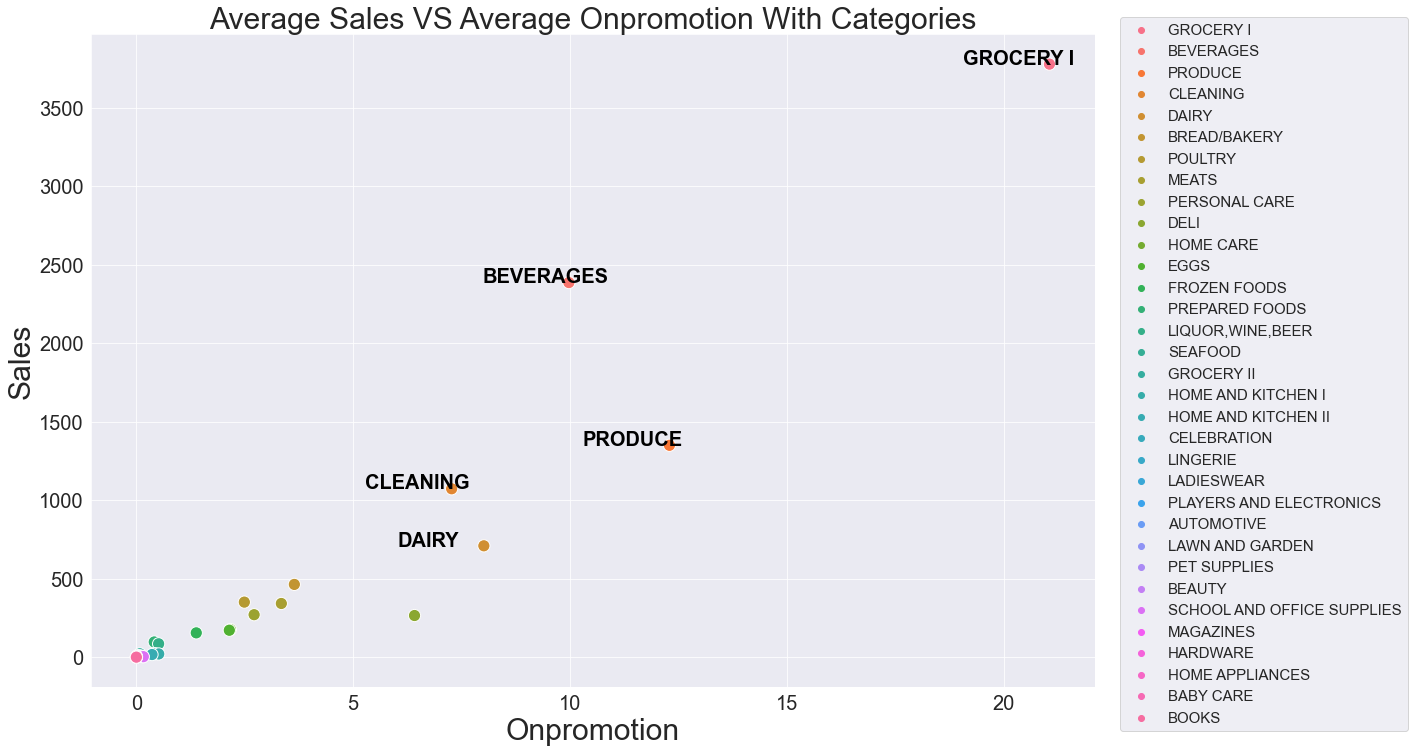

In [62]:
fig, ax = plt.subplots(figsize = (18, 12))
scatter_data = pd.concat([Train_data.groupby(['family']).mean()['sales'],
                         Train_data.groupby(['family']).mean()['onpromotion']],
                         axis = 1).sort_values(['sales'], ascending = False)
plot = sns.scatterplot(data = scatter_data, hue = scatter_data.index, x = 'onpromotion', y = 'sales', s = 150)
_ = plt.legend(bbox_to_anchor = (1.01, 1.05), fontsize = 15, loc = 'upper left', borderaxespad = 1)
for i in range(5):#Top_5_sale.index:
     plt.text(scatter_data.onpromotion[i] - 2, scatter_data.sales[i], scatter_data.index[i],
              horizontalalignment = 'left', size = 'medium', color = 'black', weight = 'semibold')
plot.set_title('Average Sales VS Average Onpromotion With Categories', fontsize = 30)
plot.set_xlabel('Onpromotion', fontsize = 30)
plot.set_ylabel('Sales', fontsize = 30)
plt.savefig('Onpromotion.png', dpi = 400, bbox_inches = 'tight')

# Plot for time and total sales(continuous VS continuous)

In [51]:
# fig, ax = plt.subplots(2, 1, figsize = (40, 23))
# sale_data = Train_data.groupby(by = ['family', 'date']).mean()['sales'].reset_index()
# plot = sns.lineplot(data = sale_data[sale_data.family.isin(Top_5_sale.index)],
#              x = 'date',
#              y = 'sales',
#              hue = 'family', 
#              ax = ax[0])
# plot.set_title('Top 5 Catories Average Sales - All Time', fontsize = 30)
# plot.set_xlabel('Time', fontsize = 25)
# plot.set_ylabel('Sales', fontsize = 25)

# plot = sns.lineplot(data = sale_data[sale_data.family.isin(Top_5_sale.index) & (sale_data.date >= pd.Timestamp("2016-01-01"))],
#              x = 'date',
#              y = 'sales',
#              hue = 'family', 
#              ax = ax[1])
# plot.set_title('Top 5 Catoryies Average Sales - Two Half Year', fontsize = 30)
# plot.set_xlabel('Time', fontsize = 25)
# _ = plot.set_ylabel('Sales', fontsize = 25)


In [52]:
# fig, ax = plt.subplots(2, 1, figsize = (27, 23))
# plot = sns.lineplot(data = sale_data[sale_data.family.isin(Top_5_sale.index) & (sale_data.date >= pd.Timestamp("2017-01-01"))],
#              x = 'date',
#              y = 'sales',
#              hue = 'family', 
#              ax = ax[0])
# plot.set_title('Top 5 Catories Average Sales - One Half Year', fontsize = 30)
# plot.set_xlabel('Time', fontsize = 25)
# plot.set_ylabel('Sales', fontsize = 25)

# plot = sns.lineplot(data = sale_data[sale_data.family.isin(Top_5_sale.index) & (sale_data.date >= pd.Timestamp("2017-07-01"))],
#              x = 'date',
#              y = 'sales',
#              hue = 'family', 
#              ax = ax[1])
# plot.set_title('Top 5 Catories Average Sales - One Half Month', fontsize = 30)
# plot.set_xlabel('Time', fontsize = 25)
# _ = plot.set_ylabel('Sales', fontsize = 25)


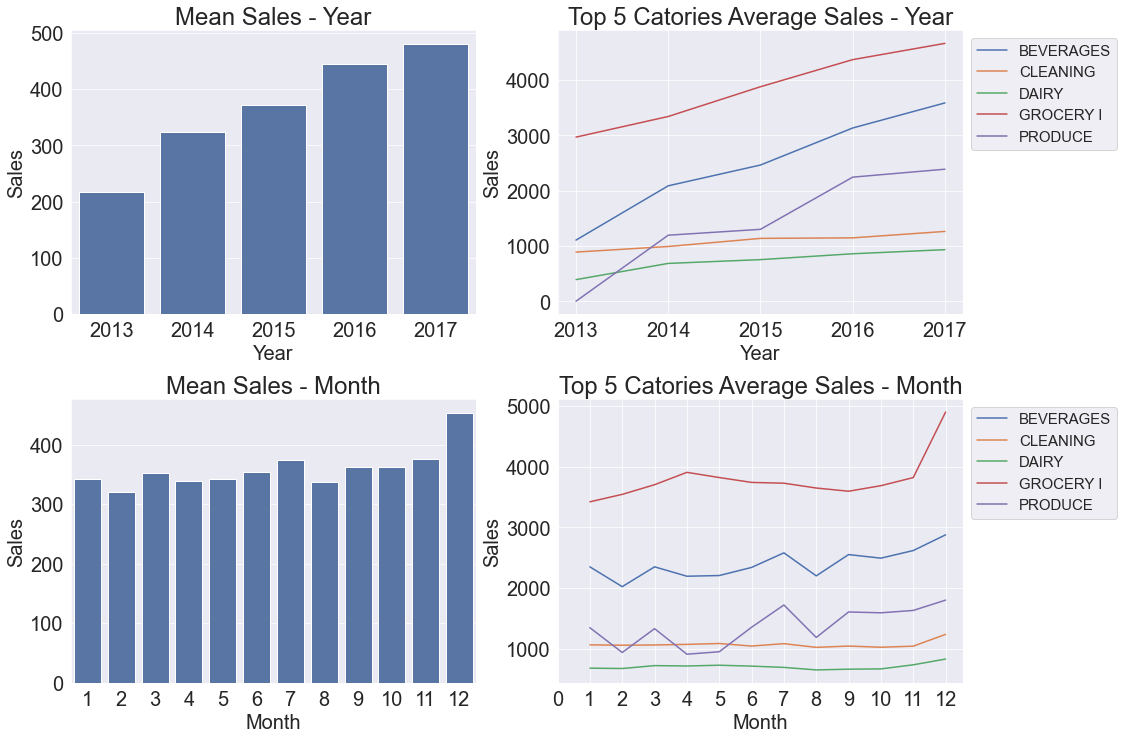

In [63]:
# Plot for time and sale(continuous VS continuous)
# 因為 2017 只到 8 月，所以求 sum 的話會比之前月份低.....
grouping_columns = ['year', 'month', 'day_name', 'day']
fig, ax = plt.subplots(2, 2, figsize = (16, 12))
# axes = ax.flat#ax.flatten()

for ind, column in enumerate(grouping_columns[:2]):
    grouped_data = Train_data.groupby(column)['sales'].mean().reset_index()
    plot = sns.barplot(data = grouped_data,
                       x = column,
                       y = 'sales',
                       color = 'b',
                       ax = ax[ind, 0])
    plot.axes.set_title('Mean Sales - ' + column.capitalize())#, fontsize = 30
#     plot.tick_params(axis = 'both', labelsize = 16)
    if column == 'day_name' : ax[ind, 0].set_xticklabels( ('Mon', 'Tue','Wed', 'Thur', 'Fri', 'Sat', 'Sun') )
    plot.set_xlabel(column.capitalize())#, fontsize = 30
    plot.set_ylabel("Sales")#, fontsize = 30
#     print(grouped_data)
    
    grouped_data = Train_data[Train_data.family.isin(Top_5_sale.index)].groupby([column, 'family']).mean()['sales']
    plot = sns.lineplot(data = grouped_data.reset_index(),
                        x = column,
                        y = 'sales',
                        hue = 'family',
                        ax = ax[ind, 1])
    plot.axes.set_title('Top 5 Catories Average Sales - ' + column.capitalize())#, fontsize = 30
    if column == 'month' :
        ax[ind, 1].set_xticks(range(len(grouped_data.unstack()) + 1))
        ax[ind, 1].set_xticklabels(range(0, 13))
    _ = plot.legend(bbox_to_anchor = (1, 1), fontsize = 15, loc = 'upper left')#, borderaxespad = 1)
    plot.set_xlabel(column.capitalize())#, fontsize = 30
    plot.set_ylabel("Sales")#, fontsize = 30  
#     print(Train_data.groupby([column, 'family']).mean()['sales'].groupby(column).mean())
    
plt.subplots_adjust(hspace = 0.3, wspace = 0.2)
plt.savefig('Year_Mon.png', dpi = 400, bbox_inches = 'tight')
# fig.delaxes(ax[2, 1])

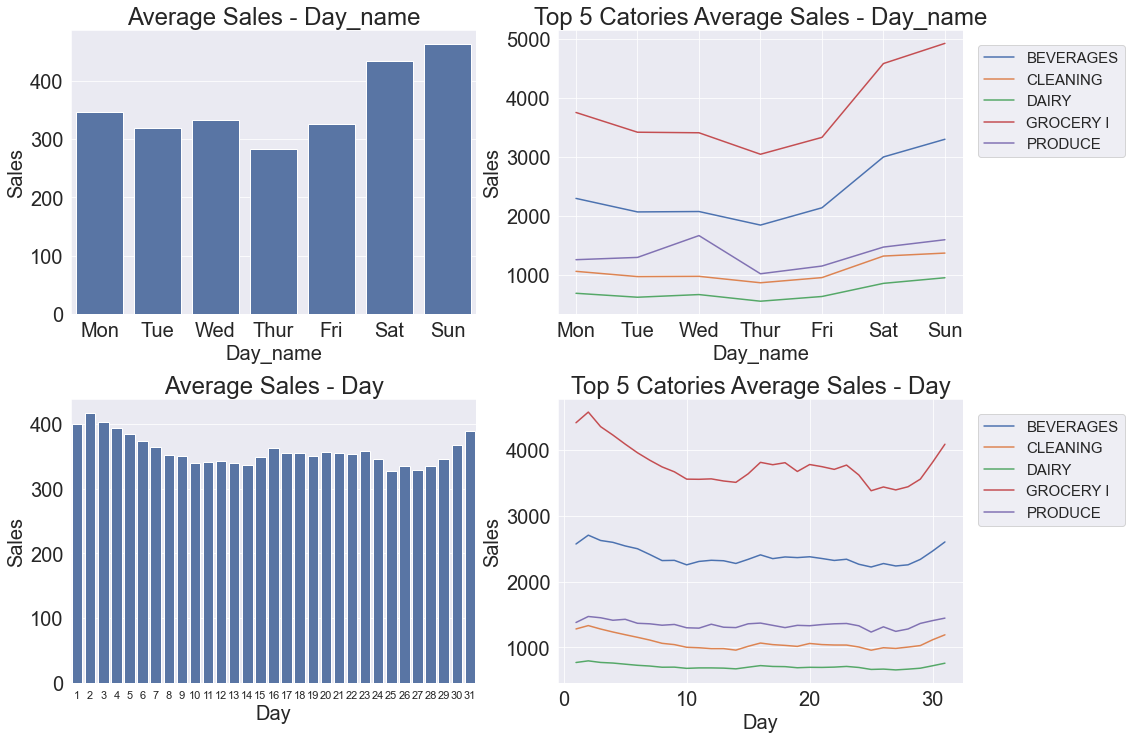

In [12]:
# Plot for time and sale(continuous VS continuous)

fig, ax = plt.subplots(2, 2, figsize = (16, 12))
# axes = ax.flat#ax.flatten()

for ind, column in enumerate(grouping_columns[2:]):
    grouped_data = Train_data.groupby(column)['sales'].mean().reset_index()
    plot = sns.barplot(data = grouped_data,
                       x = column,
                       y = 'sales',
                       color = 'b',
                       ax = ax[ind, 0])
    plot.axes.set_title('Average Sales - ' + column.capitalize())#, fontsize = 30
    if column == 'day' : plot.tick_params(axis = 'x', labelsize = 11)
    if column == 'day_name' : ax[ind, 0].set_xticklabels( ('Mon', 'Tue','Wed', 'Thur', 'Fri', 'Sat', 'Sun') )
    plot.set_xlabel(column.capitalize())#, fontsize = 30
    plot.set_ylabel("Sales")#, fontsize = 30
    
    grouped_data = Train_data[Train_data.family.isin(Top_5_sale.index)].groupby([column, 'family']).mean()['sales']
    plot = sns.lineplot(data = grouped_data.reset_index(),
                        x = column,
                        y = 'sales',
                        hue = 'family',
                        ax = ax[ind, 1])
    plot.axes.set_title('Top 5 Catories Average Sales - ' + column.capitalize())#, fontsize = 30
    if column == 'day_name' : 
        ax[ind, 1].set_xticks(range(len(grouped_data.reset_index().day_name.unique())))
        ax[ind, 1].set_xticklabels(['Mon', 'Tue','Wed', 'Thur', 'Fri', 'Sat', 'Sun'])
    _ = plot.legend(bbox_to_anchor = (1, 1), fontsize = 15, loc = 'upper left', borderaxespad = 1)
    plot.set_xlabel(column.capitalize())#, fontsize = 30
    plot.set_ylabel("Sales")#, fontsize = 30  
plt.subplots_adjust(hspace = 0.3, wspace = 0.2)
plt.savefig('Week_day.png', dpi = 400, bbox_inches = 'tight')
# fig.delaxes(ax[2, 1])

In [64]:
# Stor_per = 100 * Train_data.groupby(by = ['state']).sum()['sales'] / Train_data['sales'].sum()
# Stor_per = Stor_per.round(decimals = 3)
# Stor_per = Stor_per.sort_values(ascending = False)

# Top_4  = Stor_per[:4].copy()
# Others = pd.Series(Stor_per[4:].sum(), index = ['others'])
# stor_per = pd.concat([Top_4, Others])

# fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (30, 15), gridspec_kw = {'width_ratios': [1, 3]})
# patches, texts = ax[0].pie(Stor_per, startangle = 90, radius = 1.5)
# lables_2 = ['{0} - {1:1.2f} %'.format(i, j) for i, j in zip(Stor_per.index, Stor_per)]
# patches, labels, dummy =  zip(*sorted(zip(patches, lables_2, Stor_per),
#                                           key = lambda x: x[2],
#                                           reverse = True))

# ax[0].legend(patches, labels, loc = 'best', bbox_to_anchor=(-0.08, 0.9))#, fontsize = 10)
# ax[0].set_title('State Sales Percentage', pad = 60, fontsize = 30)
# grouped_data = Train_data.groupby(['state', 'family'])['sales'].sum()
# cluster_family = grouped_data.groupby(level = 'state', group_keys = False).apply(lambda x: x.nlargest(5))
# cluster_family = cluster_family.reset_index()

# plot = sns.barplot(data = cluster_family,
#                    x = 'state',
#                    y = 'sales',
#                    hue = 'family',
#                    ax = ax[1])
# plot.axes.set_title('Top 5 Categories Sales In Each State', fontsize = 30)
# plot.set_xlabel('State', fontsize = 25)
# plot.set_ylabel('Sales Total Amount', fontsize = 25)
# plt.subplots_adjust(wspace = 0.15)

In [65]:
# Stor_per = 100 * Train_data.groupby(by = ['city']).sum()['sales'] / Train_data['sales'].sum()
# Stor_per = Stor_per.round(decimals = 3)
# Stor_per = Stor_per.sort_values(ascending = False)

# Top_4  = Stor_per[:4].copy()
# Others = pd.Series(Stor_per[4:].sum(), index = ['others'])
# stor_per = pd.concat([Top_4, Others])

# fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (30, 15), gridspec_kw = {'width_ratios': [1, 3]})
# patches, texts = ax[0].pie(Stor_per, startangle = 90, radius = 1.5)
# lables_2 = ['{0} - {1:1.2f} %'.format(i, j) for i, j in zip(Stor_per.index, Stor_per)]
# patches, labels, dummy =  zip(*sorted(zip(patches, lables_2, Stor_per),
#                                           key = lambda x: x[2],
#                                           reverse = True))

# ax[0].legend(patches, labels, loc = 'best', bbox_to_anchor=(-0.08, 0.9))#, fontsize = 10)
# ax[0].set_title('City Sales Percentage', pad = 60, fontsize = 30)
# grouped_data = Train_data.groupby(['city', 'family'])['sales'].sum()
# cluster_family = grouped_data.groupby(level = 'city', group_keys = False).apply(lambda x: x.nlargest(5))
# cluster_family = cluster_family.reset_index()

# plot = sns.barplot(data = cluster_family,
#                    x = 'city',
#                    y = 'sales',
#                    hue = 'family',
#                    ax = ax[1])
# plot.axes.set_title('Top 5 Categories Sales In Each City', fontsize = 30)
# plot.set_xlabel('City', fontsize = 25)
# plot.set_ylabel('Sales Total Amount', fontsize = 25)
# plt.subplots_adjust(wspace = 0.15)

In [66]:
# Stor_per = 100 * Train_data.groupby(by = ['cluster']).sum()['sales'] / Train_data['sales'].sum()
# Stor_per = Stor_per.round(decimals = 3)
# Stor_per = Stor_per.sort_values(ascending = False)

# Top_4  = Stor_per[:4].copy()
# Others = pd.Series(Stor_per[4:].sum(), index = ['others'])
# stor_per = pd.concat([Top_4, Others])

# fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (30, 15), gridspec_kw = {'width_ratios': [1, 3]})
# patches, texts = ax[0].pie(Stor_per, startangle = 90, radius = 1.5)
# lables_2 = ['{0} - {1:1.2f} %'.format(i, j) for i, j in zip(Stor_per.index, Stor_per)]
# patches, labels, dummy =  zip(*sorted(zip(patches, lables_2, Stor_per),
#                                           key = lambda x: x[2],
#                                           reverse = True))
    
# ax[0].legend(patches, labels, loc = 'best', bbox_to_anchor=(-0.08, 0.9))#, fontsize = 10)
# ax[0].set_title('Cluster Sales Percentage', pad = 60, fontsize = 30)
# grouped_data = Train_data.groupby(['cluster', 'family'])['sales'].sum()
# cluster_family = grouped_data.groupby(level = 'cluster', group_keys = False).apply(lambda x: x.nlargest(5))
# cluster_family = cluster_family.reset_index()

# plot = sns.barplot(data = cluster_family,
#                    x = 'cluster',
#                    y = 'sales',
#                    hue = 'family',
#                    ax = ax[1])
# plot.axes.set_title('Top 5 Categories Sales In Each Cluster', fontsize = 30)
# plot.set_xlabel('Cluster', fontsize = 25)
# plot.set_ylabel('Sales Total Amount', fontsize = 25)
# plt.subplots_adjust(wspace = 0.15)

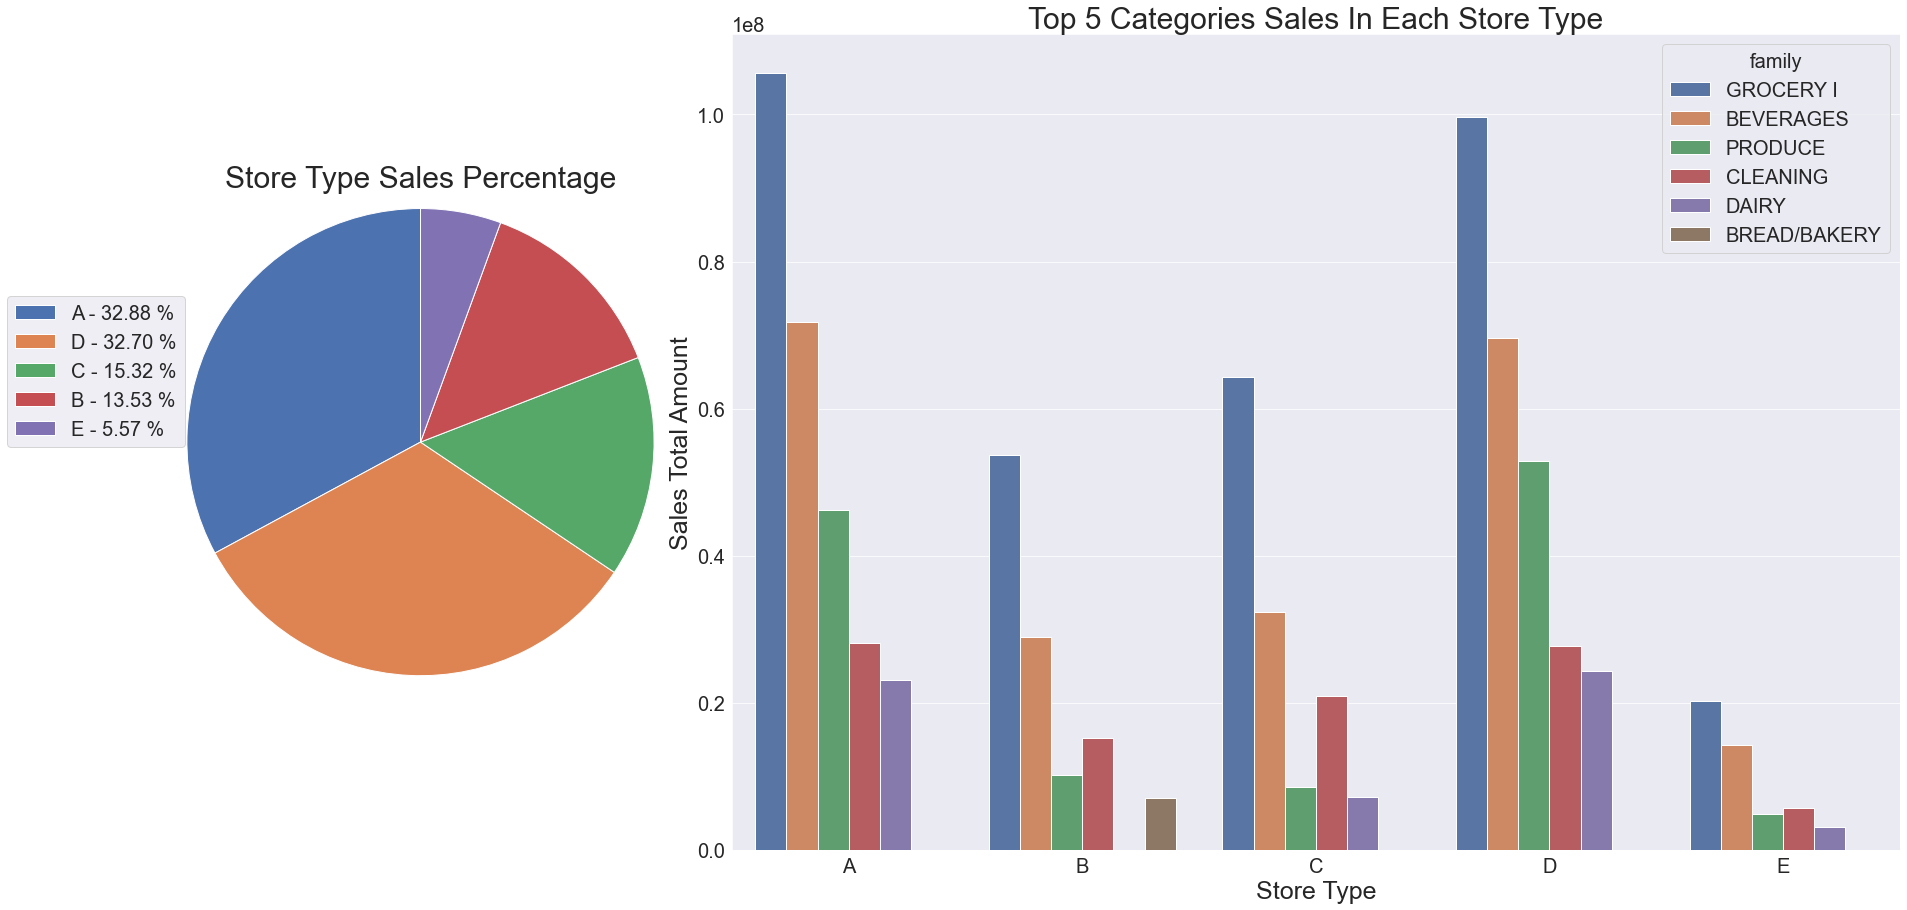

In [67]:
Stor_per = 100 * Train_data.groupby(by = ['store_type']).sum()['sales'] / Train_data['sales'].sum()
Stor_per = Stor_per.round(decimals = 3)
Stor_per = Stor_per.sort_values(ascending = False)

Top_4  = Stor_per[:4].copy()
Others = pd.Series(Stor_per[4:].sum(), index = ['others'])
stor_per = pd.concat([Top_4, Others])

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (30, 15), gridspec_kw = {'width_ratios': [1, 3]})
patches, texts = ax[0].pie(Stor_per, startangle = 90, radius = 1.5)
lables_2 = ['{0} - {1:1.2f} %'.format(i, j) for i, j in zip(Stor_per.index, Stor_per)]
patches, labels, dummy =  zip(*sorted(zip(patches, lables_2, Stor_per),
                                          key = lambda x: x[2],
                                          reverse = True))

ax[0].legend(patches, labels, loc = 'best', bbox_to_anchor=(-0.08, 0.9))#, fontsize = 10)
ax[0].set_title('Store Type Sales Percentage', pad = 60, fontsize = 30)
grouped_data = Train_data.groupby(['store_type', 'family'])['sales'].sum()
cluster_family = grouped_data.groupby(level = 'store_type', group_keys = False).apply(lambda x: x.nlargest(5))
cluster_family = cluster_family.reset_index()

plot = sns.barplot(data = cluster_family,
                   x = 'store_type',
                   y = 'sales',
                   hue = 'family',
                   ax = ax[1])
plot.axes.set_title('Top 5 Categories Sales In Each Store Type', fontsize = 30)
plot.set_xlabel('Store Type', fontsize = 25)
plot.set_ylabel('Sales Total Amount', fontsize = 25)
plt.subplots_adjust(wspace = 0.15)
plt.savefig('Store_type.png', dpi = 400, bbox_inches = 'tight')

In [68]:
# day_type = holidays[['date', 'type']]
# avg_sales = Train_data.groupby('date').agg({'sales': 'mean'}).reset_index()
# fig, ax = plt.subplots(1, 2, figsize = (27, 20))

# df = pd.merge(avg_sales, day_type, how = 'left', on = 'date')
# df.dropna(inplace = True)
# df.reset_index(drop = True, inplace = True)
# df_1 = df.groupby(['type']).mean()['sales'].reset_index()
# print(df_1)
# plot = sns.barplot(data = df_1,
#                    x = 'type',
#                    y = 'sales',
#                    color = 'b',
#                    ax = ax[0])
# plot.axes.set_title('Holiday Average Sales', fontsize = 30)
# plot.set_xlabel('Holiday', fontsize = 25)
# plot.set_ylabel('Sales', fontsize = 25)

# day_type = holidays[['date', 'type']]
# avg_sales = Train_data.groupby(['date', 'family']).agg({'sales': 'mean'}).reset_index()

# df = pd.merge(avg_sales, day_type, how = 'left', on = 'date')
# df.dropna(inplace = True)
# df.reset_index(drop = True, inplace = True)
# df_1 = df.groupby(['type', 'family']).mean()['sales'].reset_index()
# print(df_1.groupby('type').mean()['sales'])
# type_family_5 = df_1.groupby('type', group_keys = False).apply(lambda x: x.nlargest(5, 'sales'))

# plot = sns.barplot(data = type_family_5,
#                    x = 'type',
#                    y = 'sales',
#                    hue = 'family',
#                    ax = ax[1])
# plot.axes.set_title('Top 5 Categories Average Sales In Each Holiday', fontsize = 30)
# plot.set_xlabel('Holiday', fontsize = 25)
# plot.set_ylabel('Sales', fontsize = 25)
# plt.subplots_adjust(wspace = 0.15)

# Feature Engineerning

In [69]:
# Define a function to create the lagged feature
def add_lagged_features(group, lags):
    for lag in lags:
        group[f'lagged_sales_{lag}'] = group['sales'].shift(lag)
        group[f'lagged_sales_{lag}'] = group[f'lagged_sales_{lag}'].fillna(0)
    return group

# # Define a function to compute the rolling mean, std for each group
# def add_rolling_value(group, window_sizes):
#     for window_size in window_sizes:
#         group[f'rolling_mean_{window_size}_days'] = group['sales'].rolling(window_size).mean()
#         group[f'rolling_std_{window_size}_days'] = group['sales'].rolling(window_size).std()
#         group[f'rolling_max_{window_size}_days'] = group['sales'].rolling(window_size).max()
#         group[f'rolling_min_{window_size}_days'] = group['sales'].rolling(window_size).min()
        
#     return group

df.sales = np.log(df.sales + 1)
df = df.groupby(['store_nbr', 'family']).apply(add_lagged_features, lags = list([x for x in range(16, 32)]))
# df = df.groupby(['store_nbr', 'family']).apply(add_rolling_value, window_sizes = [14, 28])

df['lag_mean'] = df.loc[:, df.columns.str.startswith('lagged')].mean(axis = 1)
df['lag_std'] = df.loc[:, df.columns.str.startswith('lagged')].std(axis = 1)
df['lag_max'] = df.loc[:, df.columns.str.startswith('lagged')].max(axis = 1)
df['lag_min'] = df.loc[:, df.columns.str.startswith('lagged')].min(axis = 1)

In [70]:
# df.loc[:, ['store_nbr', 'family', 'date', df.columns.str.startswith('lag')]]
df.columns
# pd.concat([df[['store_nbr', 'family', 'date']], df.loc[:, df.columns.str.startswith('lag')]], axis = 1)

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'test',
       'year', 'month', 'day_name', 'day', 'store_type', 'oil_price',
       'lagged_sales_16', 'lagged_sales_17', 'lagged_sales_18',
       'lagged_sales_19', 'lagged_sales_20', 'lagged_sales_21',
       'lagged_sales_22', 'lagged_sales_23', 'lagged_sales_24',
       'lagged_sales_25', 'lagged_sales_26', 'lagged_sales_27',
       'lagged_sales_28', 'lagged_sales_29', 'lagged_sales_30',
       'lagged_sales_31', 'lag_mean', 'lag_std', 'lag_max', 'lag_min'],
      dtype='object')

In [71]:
# categorical_features = ['family', 'day_name', 'city', 'state', 'type_x', 'transferred', 'locale', 'type_y']
# df['family_new'] = Top_5_sale.index if df['family'] in Top_5_sale.index else 'others'
# df['family'] = df['family'].astype('category')

df['family_new'] = np.where(df['family'].isin(Top_5_sale.index), df['family'], 'others')
df = pd.get_dummies(df, columns = ['family_new'], prefix = 'Family')
# df = pd.get_dummies(df, columns = ['family'], prefix = 'Family')

# df = pd.get_dummies(df, columns = ['cluster'], prefix = 'Cluster')
df = pd.get_dummies(df, columns = ['store_type'], prefix = 'Store_Type')
# df['City'] = np.where(df['city'].isin(['Quito', 'Guayaquil']), df['city'], 'others')
# df = pd.get_dummies(df, columns = ['City'], prefix = 'City')
# df['State'] = np.where(df['state'].isin(['Pichincha', 'Guayas']), df['state'], 'others')
# df = pd.get_dummies(df, columns = ['State'], prefix = 'State')

# df = pd.get_dummies(df, columns = ['type'], prefix = 'Type')
# df = pd.get_dummies(df, columns = ['locale'], prefix = 'locale')
# df = pd.get_dummies(df, columns = ['transferred'], prefix = 'Transferred')

# df = pd.get_dummies(df, columns = ['city'], prefix = 'city')
# df = pd.get_dummies(df, columns = ['state'], prefix = 'state')

# For specific time
# df = pd.get_dummies(df, columns = ['year'], prefix = 'Year')
# df['is_December'] = np.where(df['month'] == 12, 1, 0)
# df['is_Weekend'] = df.day_name.isin([5, 6]).astype(int)
# df['specific_Day'] = df.day.isin([1, 2, 16, 30, 31]).astype(int)

In [72]:
Train_data = df[df.test == 0].drop(['id', 'store_nbr', 'family', 'test'], axis = 1).copy()
Test_data = df[df.test == 1].drop(['id', 'date', 'store_nbr', 'family', 'test'], axis = 1).copy()

# X_train = Train_data.loc[Train_data['date'] < '2017/07/15']
X_train = Train_data.loc[Train_data['date'] < '2017/08/01']
# x_test = Train_data.loc[(Train_data['date'] >= '2017/07/15') & (Train_data['date'] < '2017/08/01')]
X_test = Train_data.loc[Train_data['date'] >= '2017/08/01']
# X_train_others = Train_data.loc[(Train_data['date'] < '2017/07/15') & (~Train_data['family'].isin(Top_5_sale.index))]
# x_test_others = Train_data.loc[(Train_data['date'] >= '2017/07/15') & (Train_data['date'] < '2017/08/01') & (~Train_data['family'].isin(Top_5_sale.index))]
# X_test_others = Train_data.loc[(Train_data['date'] >= '2017/08/01') & (~Train_data['family'].isin(Top_5_sale.index))]

# Y_train = Train_data.loc[Train_data['date'] < '2017/07/15']['sales']
Y_train = Train_data.loc[Train_data['date'] < '2017/08/01']['sales']
# y_test = Train_data.loc[(Train_data['date'] >= '2017/07/15') & (Train_data['date'] < '2017/08/01')]['sales']
Y_test = Train_data.loc[Train_data['date'] >= '2017/08/01']['sales']
# Y_train_others = Train_data.loc[(Train_data['date'] < '2017/07/15') & (~Train_data['family'].isin(Top_5_sale.index))]['sales']
# y_test_others = Train_data.loc[(Train_data['date'] >= '2017/07/15') & (Train_data['date'] < '2017/08/01') & (~Train_data['family'].isin(Top_5_sale.index))]['sales']
# Y_test_others = Train_data.loc[(Train_data['date'] >= '2017/08/01') & (~Train_data['family'].isin(Top_5_sale.index))]['sales']

In [73]:
days = X_train.date.unique()
splits = []
tscv = TimeSeriesSplit(n_splits = 5, max_train_size = 365, test_size = 15)

# TimeSeriesSplit can not use dateindex as index.
for i, (train_index, test_index) in enumerate(tscv.split(days)):
    dtrain = X_train[X_train['date'].isin(days[train_index])]
    dtest = X_train[X_train['date'].isin(days[test_index])]
    splits.append((dtrain.index, dtest.index)) 

# days = Train_data.date.unique()
# splits = []

# tscv = TimeSeriesSplit(n_splits = 5, max_train_size = 365, test_size = 15)

# # TimeSeriesSplit can not use dateindex as index.
# for i, (train_index, test_index) in enumerate(tscv.split(days)):
#     dtrain = Train_data[Train_data['date'].isin(days[train_index])]
#     dtest = Train_data[Train_data['date'].isin(days[test_index])]
#     splits.append((dtrain.index, dtest.index))

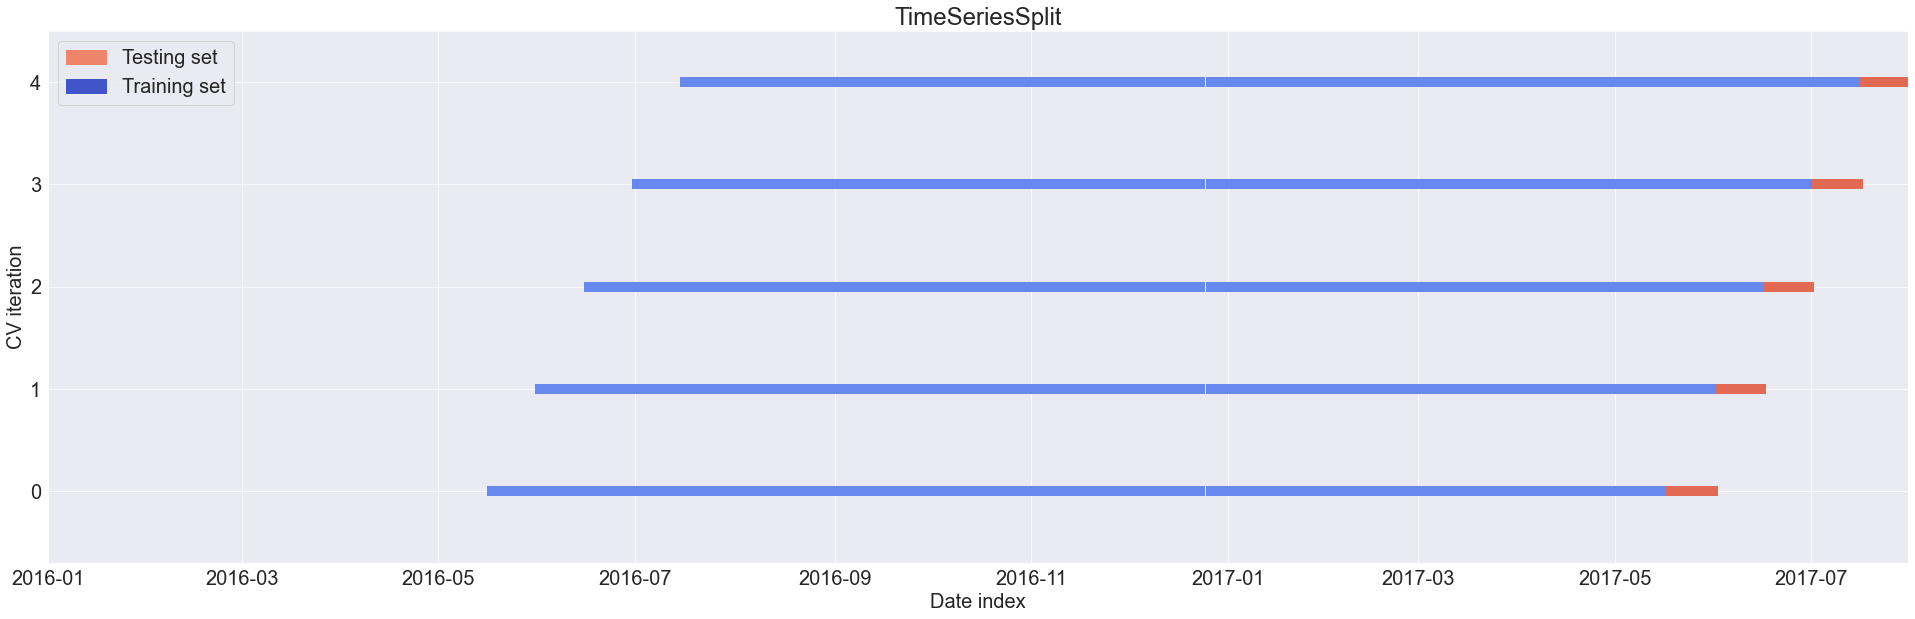

In [74]:
from matplotlib.patches import Patch

cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

def plot_cv_indices(cv, X, ax, n_splits, lw = 10):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X = X)):
        # Fill in indices with the training/test groups
        indices = pd.DataFrame(np.array([np.nan] * len(X)), index = X)
        indices.loc[X[tt]] = 1
        indices.loc[X[tr]] = 0

        # Visualize the results
        ax.scatter(
            pd.to_datetime(X),#range(len(indices)),
            [ii + 0.5] * len(indices),
            c = indices,
            marker = "_",
            lw = lw,
            cmap = cmap_cv,
            vmin = -0.2,
            vmax = 1.2,
        )

    # Formatting
    yticklabels = list(range(n_splits))#list(range(n_splits)) + ["class", "group"]
    ax.set(
        yticks = np.arange(n_splits) + 0.5,#np.arange(n_splits + 2) + 0.5,
        yticklabels = yticklabels,
        xlabel = "Date index",
        ylabel = "CV iteration",
        ylim = [-0.2, n_splits],
        xlim = [pd.to_datetime('2016/01/01'), X.max()],
    )
    ax.set_title("{}".format(type(cv).__name__))#, fontsize=15)
    return ax

fig, ax = plt.subplots(figsize = (27, 9))
plot_cv_indices(tscv, days, ax, n_splits = 5)

ax.legend(
    [Patch(color = cmap_cv(0.8)), Patch(color = cmap_cv(0.02))],
    ["Testing set", "Training set"],
    loc = 'upper left'#(1.02, 0.8),
    )
# Make the legend fit
plt.tight_layout()
# plt.savefig('CV.png', dpi = 400, bbox_inches = 'tight')

In [15]:
%%time

# feature selection first
# Fit the model calculated from colab.
reg = xgb.XGBRegressor(
    booster = 'gbtree',
    objective = 'reg:squaredlogerror',
    n_estimators = 1000,
    early_stopping_rounds = 500,
    random_state = 1234)

Model = reg.fit(
    X_train.drop(['sales', 'date'], axis = 1),
    Y_train,
    eval_set = [(X_train.drop(['sales', 'date'], axis = 1), Y_train),
                (X_test.drop(['sales', 'date'], axis = 1), Y_test)],
    verbose = 100) 

[0]	validation_0-rmsle:0.92753	validation_1-rmsle:1.01934
[100]	validation_0-rmsle:nan	validation_1-rmsle:nan
[200]	validation_0-rmsle:nan	validation_1-rmsle:nan
[300]	validation_0-rmsle:nan	validation_1-rmsle:nan
[400]	validation_0-rmsle:nan	validation_1-rmsle:nan
[500]	validation_0-rmsle:nan	validation_1-rmsle:nan
[508]	validation_0-rmsle:nan	validation_1-rmsle:nan
Wall time: 7min 42s


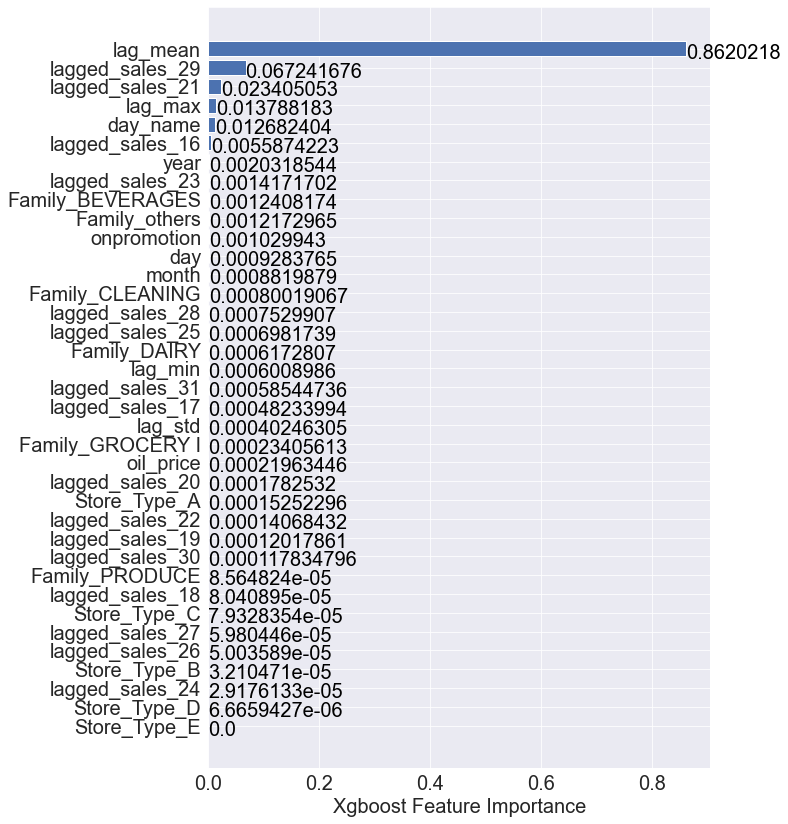

In [45]:
sorted_idx = Model.feature_importances_.argsort()
fig, ax = plt.subplots(figsize = (9, 14))
hbars = ax.barh(X_train.drop(['sales', 'date'], axis = 1).columns[sorted_idx],
                Model.feature_importances_[sorted_idx])
for i, v in enumerate(Model.feature_importances_[sorted_idx]):
    ax.text(v, i-0.5, str(v), color='black')#,
#               horizontalalignment = 'left', weight = 'semibold')
plt.xlabel("Xgboost Feature Importance")
plt.savefig('Imp.png', dpi = 400, bbox_inches = 'tight')
# plt.text(scatter_data.onpromotion[i] - 2, scatter_data.sales[i], scatter_data.index[i],
#               horizontalalignment = 'left', size = 'medium', color = 'black', weight = 'semibold')

In [13]:
%%time
# Fit the model calculated from colab.
reg = xgb.XGBRegressor(
    booster = 'gbtree',
    objective = 'reg:squaredlogerror',
#     tree_method = "hist",
#     device = "gpu",
    learning_rate = 0.03,
    max_depth = 3,
    n_estimators = 2000,
    early_stopping_rounds = 500,
    random_state = 1234)
Model = reg.fit(
    X_train.drop(['sales', 'date'], axis = 1),
    Y_train,
    eval_set = [(X_train.drop(['sales', 'date'], axis = 1), Y_train),
                (X_test.drop(['sales', 'date'], axis = 1), Y_test)],
    verbose = 100)
# No evaluation set were set, so there were no validation error output.
# So 'verbose' here is no functional 

[0]	validation_0-rmsle:1.03764	validation_1-rmsle:1.13750
[100]	validation_0-rmsle:0.34546	validation_1-rmsle:0.28401
[200]	validation_0-rmsle:0.28919	validation_1-rmsle:0.18649
[300]	validation_0-rmsle:nan	validation_1-rmsle:0.18174
[400]	validation_0-rmsle:nan	validation_1-rmsle:0.18117
[500]	validation_0-rmsle:nan	validation_1-rmsle:0.18113
[600]	validation_0-rmsle:nan	validation_1-rmsle:0.18113
[700]	validation_0-rmsle:nan	validation_1-rmsle:0.18104
[800]	validation_0-rmsle:nan	validation_1-rmsle:0.18103
[900]	validation_0-rmsle:nan	validation_1-rmsle:0.18068
[1000]	validation_0-rmsle:nan	validation_1-rmsle:0.18050
[1100]	validation_0-rmsle:nan	validation_1-rmsle:0.18049
[1200]	validation_0-rmsle:nan	validation_1-rmsle:0.18049
[1300]	validation_0-rmsle:nan	validation_1-rmsle:0.18047
[1400]	validation_0-rmsle:nan	validation_1-rmsle:0.18043
[1500]	validation_0-rmsle:nan	validation_1-rmsle:0.18040
[1600]	validation_0-rmsle:nan	validation_1-rmsle:0.18037
[1700]	validation_0-rmsle:nan	v

In [181]:
# Fit the model calculated from colab.
reg = xgb.XGBRegressor(
    booster = 'gbtree',
    objective = 'reg:squaredlogerror',
    learning_rate = 0.2,
    max_depth = 5,
#     colsample_bytree = 0.7,
    n_estimators = 1000,
    early_stopping_rounds = 500,
    random_state = 1234)
Model = reg.fit(
    X_train.drop(['sales', 'date'], axis = 1),
    Y_train,
    eval_set = [(X_train.drop(['sales', 'date'], axis = 1), Y_train),
                (x_test.drop(['sales', 'date'], axis = 1), y_test)], 
    verbose = 100)

[0]	validation_0-rmsle:3.47685	validation_1-rmsle:3.85994
[100]	validation_0-rmsle:nan	validation_1-rmsle:1.48512
[200]	validation_0-rmsle:nan	validation_1-rmsle:1.48487
[300]	validation_0-rmsle:nan	validation_1-rmsle:1.48433
[400]	validation_0-rmsle:nan	validation_1-rmsle:1.48417
[500]	validation_0-rmsle:nan	validation_1-rmsle:1.48379
[518]	validation_0-rmsle:nan	validation_1-rmsle:1.48378


In [186]:
y_pred_xgb = Model.predict(X_test.drop(['sales', 'date'], axis = 1))
print(mean_squared_log_error(abs(Y_test), abs(y_pred_xgb), squared = False))

sample_submission['sales'] = Model.predict(Test_data.drop(['sales'], axis = 1))
# sum(sample_submission.sales < 0) # 670
# sample_submission.loc[sample_submission.sales < 1, ['sales']] = 0
# sum(sample_submission.sales < 0) # 0
sample_submission.to_csv('submission_all.csv', index=False)

1.1738198049021396


In [54]:
# TESTING
# for train & test in fit function

# params = {
#     'booster':['gbtree'],
#     'objective' : ['reg:squaredlogerror'],
#     'n_estimators': [2000],
#     'max_depth': [3, 4, 5],
#     'learning_rate': [0.05, 0.1, 0.15, 0.2],
#     'random_state': [1234]
#     }
# fit_params={
#     "early_stopping_rounds": 200,
#     "eval_metric" : "reg:squaredlogerror",
#     "verbose" : 100,
#     "eval_set" : [[X_test.drop(['sales', 'date'], axis = 1), y_test]]
#     }

# reg = xgb.XGBRegressor()

# gsc = GridSearchCV(
#     reg,
#     param_grid = params,
#     n_jobs = -1,
#     cv = splits,
#     verbose = 1 # check
#     )

# xgb_grid_model = gsc.fit(X_train.drop(['sales', 'date'], axis = 1), y_train, **fit_params)